# **Time Series Forecasting with Transformers**

**Objective**: Create a **Transformers-based model** in **Keras** to **predict future values** ​​of a time series.
- **Dataset**: We will use daily temperature data from a city.
- **Applied Skills**:

   - Time Series Preprocessing
   - Using Tensors and Operations with TensorFlow
   - Implementing a Transformer Encoder
   - Training and Evaluation of the Model
   - Visualizing the Forecasts

In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Input, BatchNormalization
from tensorflow.keras.models import Model

**Steps**
1. **Loading and Preprocessing Data**
- We import a **time series dataset** (e.g. daily temperature)
- We **normalize the data** and create an input sequence for the model.

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Define the number of timesteps (days in a year)
timesteps = 365

# Create a linear trend component (increasing from 10 to 30)
trend = np.linspace(10, 30, timesteps)

# Create a seasonal component using a sine wave
seasonal = 5 * np.sin(np.linspace(0, 2 * np.pi, timesteps))

# Generate random noise with mean 0 and standard deviation 2
noise = np.random.normal(0, 2, timesteps)

# Combine trend, seasonality, and noise to create the time series data
data = trend + seasonal + noise

In [ ]:
# Creiamo i dati di input per il modello
def create_sequences(data, window_size):
    """
    Generates input sequences and corresponding target values for a time series.

    Args:
        data (array-like): The time series data.
        window_size (int): The size of the sliding window used to create sequences.

    Returns:
        tuple: A tuple containing the input sequences (X) and target values (y).
    """
    X, y = [], [] # Initialize empty lists to store input sequences (X) and target values (y)
    for i in range(len(data) - window_size): # Iterate through the data, leaving space for the window
        X.append(data[i:i+window_size]) # Extract a window of data and add it to X
        y.append(data[i+window_size]) # Add the next value
    return np.array(X), np.array(y)

In [ ]:
window_size = 60  # Define the size of the sliding window (60 data points)
X, y = create_sequences(data, window_size)  # Create input sequences (X) and targets (y) using the function
X = X[..., np.newaxis]  # Add a new axis to X to make it compatible with the model (shape: [samples, timesteps, features])

In [ ]:
# Split the data into training and testing sets
split = int(0.8 * len(X))  # Calculate the split index (80% of the data for training)
X_train, y_train = X[:split], y[:split]  # Assign data before the split index to training sets
X_test, y_test = X[split:], y[split:]  # Assign data after the split index to testing sets

# Normalize the data
mean = np.mean(X_train)  # Calculate the mean of the training data
std = np.std(X_train)  # Calculate the standard deviation of the training data
X_train = (X_train - mean) / std  # Normalize the training data using Z-score normalization
X_test = (X_test - mean) / std  # Normalize the testing data using the same mean and std from training

y_mean = np.mean(y_train)  # Calculate the mean of the training target values
y_std = np.std(y_train)  # Calculate the standard deviation of the training target values
y_train = (y_train - y_mean) / y_std  # Normalize the training target values
y_test = (y_test - y_mean) / y_std  # Normalize the testing target values

## Transformer Model Construction

This section implements a Transformer Encoder using TensorFlow and Keras. It defines the core components of a Transformer Encoder layer: Multi-Head Attention, Layer Normalization, and a Feed-Forward Network.

### Layers and Architecture

The `TransformerEncoderLayer` is built using the following layers:

#### Multi-Head Attention Layer (`self.attn`)

- **Purpose**: This layer is the heart of the Transformer. It allows the model to attend to different parts of the input sequence and learn relationships between them.
- **Functionality**: It uses multiple "heads" (specified by `num_heads`) to focus on different aspects of the data, improving the model's ability to capture complex patterns.
- **Implementation**: In this implementation, it's using `tf.keras.layers.MultiHeadAttention`.

#### Layer Normalization Layers (`self.norm1`, `self.norm2`)

- **Purpose**: Layer Normalization is applied after the Multi-Head Attention and the Feed-Forward Network.
- **Functionality**: It normalizes the activations within each layer, stabilizing and accelerating the training process. It normalizes the inputs across the features, as opposed to Batch Normalization which normalizes across the batch.
- **Implementation**: Keras' `LayerNormalization` is used here with a small epsilon value for numerical stability.

#### Feed-Forward Network (`self.ffn`)

- **Purpose**: This is a traditional feed-forward neural network consisting of two dense layers with a ReLU activation in between.
- **Functionality**: It processes the output of the Multi-Head Attention layer.
- **Implementation**: L2 regularization is applied to the dense layers to prevent overfitting (`kernel_regularizer=tf.keras.regularizers.l2(1.00)`).

#### Dropout Layers (`self.dropout1`, `self.dropout2`)

- **Purpose**: Dropout is a regularization technique used to prevent overfitting.
- **Functionality**: It randomly ignores a fraction of neurons during training, forcing the network to learn more robust features.
- **Implementation**: Dropout is applied after the Multi-Head Attention and the Feed-Forward Network.

### Data Flow

1. The input data (`inputs`) is first passed through the Multi-Head Attention layer (`self.attn`).
2. Dropout is applied to the attention output (`self.dropout1`).
3. The attention output is added to the original input, and the result is normalized using Layer Normalization (`self.norm1`).
4. This normalized output is then fed into the Feed-Forward Network (`self.ffn`).
5. Dropout is applied to the output of the Feed-Forward Network (`self.dropout2`).
6. The output of the Feed-Forward Network is added to the output of step 3, and the result is normalized using Layer Normalization (`self.norm2`).
7. This final normalized output is returned by the `call` method.



In [ ]:
# Definition of the Transformer Encoder
class TransformerEncoderLayer(Layer):  # Define a custom layer class called 'TransformerEncoderLayer', inheriting from 'Layer'
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.3):  # Initialize the layer with parameters
        super(TransformerEncoderLayer, self).__init__()  # Call the constructor of the parent class (Layer)
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)  # Create a Multi-Head Attention layer
        self.norm1 = LayerNormalization(epsilon=1e-6)  # Create a Layer Normalization layer (norm1)
        self.norm2 = LayerNormalization(epsilon=1e-6)  # Create another Layer Normalization layer (norm2)
        self.ffn = tf.keras.Sequential([  # Create a feed-forward network (ffn) as a sequential model
            Dense(ff_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1.00)),  # Dense layer with ReLU and L2 regularization
            Dropout(dropout),  # Dropout layer
            Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(1.00))  # Another dense layer with L2 regularization
        ])
        self.dropout1 = Dropout(dropout)  # Create a Dropout layer (dropout1)
        self.dropout2 = Dropout(dropout)  # Create another Dropout layer (dropout2)

    def call(self, inputs, training=False):  # Define the forward pass of the layer
        attn_output = self.attn(inputs, inputs)  # Apply Multi-Head Attention to the inputs
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout1 to the attention output
        out1 = self.norm1(inputs + attn_output)  # Add inputs and attention output, then normalize with norm1
        ffn_output = self.ffn(out1, training=training)  # Pass the output through the feed-forward network
        ffn_output = self.dropout2(ffn_output, training=training)  # Apply dropout2 to the ffn output
        return self.norm2(out1 + ffn_output)  # Add out1 and ffn output, then normalize with norm2 and return

## Transformer Model Construction

This section implements a Transformer-based model for time series forecasting using TensorFlow and Keras. It combines a Dense layer, Batch Normalization, Dropout, two Transformer Encoder layers, Global Average Pooling, and a final Dense layer for prediction.

### Layers and Architecture

The `create_transformer_model` function constructs a model with the following layers:

#### Input Layer

- **Purpose**: Receives the time series data with the specified input shape.
- **Functionality**: Acts as the entry point for the data into the model.
- **Implementation**: `Input(shape=input_shape)`

#### Dense Layer

- **Purpose**: Applies a linear transformation to the input data.
- **Functionality**: Extracts features from the input sequence.
- **Implementation**: `Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))`
  - Uses 128 neurons.
  - ReLU activation function introduces non-linearity.
  - L2 regularization helps prevent overfitting.

#### Batch Normalization Layer

- **Purpose**: Normalizes the activations of the previous layer.
- **Functionality**: Improves training stability and speed by reducing internal covariate shift.
- **Implementation**: `BatchNormalization()`

#### Dropout Layer

- **Purpose**: Randomly sets a fraction of input units to 0 during training.
- **Functionality**: Helps prevent overfitting by reducing dependence on individual neurons.
- **Implementation**: `Dropout(0.3)` (30% dropout rate)

#### Transformer Encoder Layers (x2)

- **Purpose**: The core of the model, responsible for capturing temporal dependencies.
- **Functionality**: Uses Multi-Head Attention to learn relationships between different parts of the input sequence. Includes Layer Normalization and a Feed-Forward Network within each encoder layer.
- **Implementation**: `TransformerEncoderLayer(embed_dim=128, num_heads=2, ff_dim=256, dropout=0.3)`
  - `embed_dim`: Dimensionality of the embedding space (128).
  - `num_heads`: Number of attention heads (2).
  - `ff_dim`: Dimensionality of the feed-forward network (256).
  - `dropout`: Dropout rate within the encoder layer (0.3).

#### Global Average Pooling 1D Layer

- **Purpose**: Averages the output of the Transformer Encoder layers across the time dimension.
- **Functionality**: Reduces the dimensionality of the data while preserving important information.
- **Implementation**: `tf.keras.layers.GlobalAveragePooling1D()`

#### Output Layer

- **Purpose**: Produces the final prediction.
- **Functionality**: Maps the processed features to a single output value.
- **Implementation**: `Dense(1)` (single neuron for regression)


In [ ]:
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))(inputs)
    x = BatchNormalization()(x)  # BatchNormalization mantiene la stabilità
    x = Dropout(0.3)(x)  # Dropout ridotto
    x = TransformerEncoderLayer(embed_dim=128, num_heads=2, ff_dim=256, dropout=0.3)(x)
    x = TransformerEncoderLayer(embed_dim=128, num_heads=2, ff_dim=256, dropout=0.3)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

model = create_transformer_model((window_size, 1))

## Learning Rate

The learning rate is a crucial hyperparameter that controls the step size during the optimization process. It determines how much the model's weights are adjusted based on the calculated error.

- A smaller learning rate means the model's weights are updated more slowly, leading to more stable training but potentially requiring more time to converge.
- A larger learning rate can lead to faster convergence, but it may also cause the model to overshoot the optimal solution and oscillate or diverge.

## Learning Rate Scheduler (`lr_scheduler`)

### ReduceLROnPlateau

This learning rate scheduler automatically reduces the learning rate when a metric (in this case, `val_loss`) has stopped improving.

- **monitor='val_loss'**: It monitors the validation loss to determine if the model is improving.
- **factor=0.5**: When the validation loss plateaus, the learning rate is reduced by a factor of 0.5 (halved).
- **patience=3**: The scheduler waits for 3 epochs (patience) without improvement before reducing the learning rate.
- **min_lr=1e-6**: This sets a lower bound for the learning rate, preventing it from getting too small and potentially hindering training.

## Optimizer (`AdamW`)

### AdamW (Adam with Weight Decay)

AdamW is a variant of the popular Adam optimizer, often preferred for training deep learning models, especially Transformers. It combines the benefits of Adam (adaptive learning rates) with weight decay, a regularization technique that helps prevent overfitting.

- **learning_rate=initial_learning_rate**: Sets the initial learning rate for the AdamW optimizer.
- **clipnorm=1.0**: Clips the gradients to a maximum norm of 1.0. This helps prevent exploding gradients, which can destabilize training.

## `model.compile()`

This function configures the model for training.

- **optimizer**: Specifies the optimization algorithm to use (AdamW in this case).
- **loss**: Defines the loss function to minimize during training (Mean Squared Error - 'mse' here).

## `model.summary()`

Prints a summary of the model's architecture, including the layers, output shapes, and the number of trainable parameters. This is useful for understanding the structure of your model.

- **MSE (Mean Squared Error) Loss Function**:
MSE is a loss function that **calculates the mean squared difference** between the **predicted and actual values**, penalizing larger errors more.


In [ ]:
# Learning Rate and Optimizer Configuration

initial_learning_rate = 3e-4  # Set the initial learning rate to 0.0003

# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
#    initial_learning_rate, decay_steps=80, end_learning_rate=final_learning_rate
# )
# This is an example of a learning rate scheduler that gradually decreases
# the learning rate over time. It's commented out here, but you can use it
# instead of ReduceLROnPlateau if desired.

# Learning Rate Scheduler using ReduceLROnPlateau
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss for learning rate adjustments
    factor=0.5,        # Reduce the learning rate by a factor of 0.5 (halve it)
    patience=3,        # Number of epochs with no improvement after which to reduce LR
    min_lr=1e-6       # Minimum learning rate (to prevent it from going to zero)
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=initial_learning_rate, clipnorm=1.0),
    loss='mse'  # Use Mean Squared Error as the loss function
)

# Print a summary of the model's architecture
model.summary()

Model: "functional_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_151 (InputLayer)         │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_302 (Dense)                    │ (None, 60, 128)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 60, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_427 (Dropout)                │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_layer_97         │ (None, 60, 128)             │         198,400 │
│ (TransformerEncoderLayer)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_layer_98         │ (None, 60, 128)             │         198,400 │
│ (TransformerEncoderLayer)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_54          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_307 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 397,697 (1.52 MB)

 Trainable params: 397,441 (1.52 MB)

 Non-trainable params: 256 (1.00 KB)

## Model: "functional_150"

| Layer (type)                     | Output Shape       | Param #    |
|----------------------------------|--------------------|------------|
| input_layer_148 (InputLayer)     | (None, 60, 1)      | 0          |
| dense_296 (Dense)                | (None, 60, 128)    | 256        |
| batch_normalization_39           | (None, 60, 128)    | 512        |
| (BatchNormalization)             |                    |            |
| dropout_418 (Dropout)            | (None, 60, 128)    | 0          |
| transformer_encoder_layer_95     | (None, 60, 128)    | 198,400    |
| (TransformerEncoderLayer)        |                    |            |
| transformer_encoder_layer_96     | (None, 60, 128)    | 198,400    |
| (TransformerEncoderLayer)        |                    |            |
| global_average_pooling1d_53      | (None, 128)        | 0          |
| (GlobalAveragePooling1D)         |                    |            |
| dense_301 (Dense)                | (None, 1)          | 129        |

**Total params**: 397,697 (1.52 MB)  
**Trainable params**: 397,441 (1.52 MB)  
**Non-trainable params**: 256 (1.00 KB)  

### Explanation of the Table Structure

- **Layer (type)**: The name and type of the layer.
- **Output Shape**: The shape of the output produced by the layer.
- **Param #**: The number of trainable parameters in the layer.

### Layer Details

1. **Input Layer**:
   - **Layer (type)**: `input_layer_148 (InputLayer)`
   - **Output Shape**: `(None, 60, 1)`
   - **Param #**: `0`
   - **Description**: Receives input data with the specified shape `(60, 1)`.

2. **Dense Layer**:
   - **Layer (type)**: `dense_296 (Dense)`
   - **Output Shape**: `(None, 60, 128)`
   - **Param #**: `256`
   - **Description**: Applies a linear transformation with 128 neurons and ReLU activation.

3. **Batch Normalization Layer**:
   - **Layer (type)**: `batch_normalization_39 (BatchNormalization)`
   - **Output Shape**: `(None, 60, 128)`
   - **Param #**: `512`
   - **Description**: Normalizes activations to improve training stability and speed.

4. **Dropout Layer**:
   - **Layer (type)**: `dropout_418 (Dropout)`
   - **Output Shape**: `(None, 60, 128)`
   - **Param #**: `0`
   - **Description**: Applies dropout to prevent overfitting by randomly deactivating 30% of the units during training.

5. **Transformer Encoder Layers**:
   - **Layer (type)**: `transformer_encoder_layer_95 (TransformerEncoderLayer)`
   - **Output Shape**: `(None, 60, 128)`
   - **Param #**: `198,400`
   - **Description**: Captures temporal dependencies using multi-head attention and a feed-forward network.
   - **Layer (type)**: `transformer_encoder_layer_96 (TransformerEncoderLayer)`
   - **Output Shape**: `(None, 60, 128)`
   - **Param #**: `198,400`
   - **Description**: A second Transformer Encoder layer to further capture temporal dependencies.

6. **Global Average Pooling 1D Layer**:
   - **Layer (type)**: `global_average_pooling1d_53 (GlobalAveragePooling1D)`
   - **Output Shape**: `(None, 128)`
   - **Param #**: `0`
   - **Description**: Reduces data dimensionality by averaging along the time dimension.

7. **Output Layer**:
   - **Layer (type)**: `dense_301 (Dense)`
   - **Output Shape**: `(None, 1)`
   - **Param #**: `129`
   - **Description**: Produces the final prediction with a single neuron for regression.

### Total Parameters

- **Total params**: `397,697` (1.52 MB)
  - The total number of parameters in the model, including trainable and non-trainable parameters.
- **Trainable params**: `397,441` (1.52 MB)
  - The number of parameters that will be updated during training.
- **Non-trainable params**: `256` (1.00 KB)
  - The number of parameters that will not be updated during training (e.g., normalization parameters).

This table provides a detailed overview of the model structure, showing how data flows through the various layers and the number of parameters involved in each layer.

In [ ]:
# We implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

 This technique is used to **prevent overfitting** and improve the model's ability to generalize to new, unseen data.

- **Monitoring a metric**: Watching a metric like validation loss (*val_loss*) to assess **model performance on unseen data**.
- **Waiting for improvement**: **Allowing a certain number of epochs** (*patience*) for the metric to improve **before stopping**.
- **Restoring best weights**: **Reverting to the model weights** that achieved the **best performance** on the monitored metric.

In [ ]:
# Training
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


**`.fit()` Arguments:**

* **`X_train`:** Training data (input features).
* **`y_train`:** Target values for training data.
* **`epochs`:** Number of training iterations over the entire dataset (default: 1).
* **`batch_size`:** Number of samples processed before updating model weights (default: 32).
* **`validation_data`:** Data used to evaluate the model during training.
* **`verbose`:** Controls the amount of training output (0: silent, 1: progress bar, 2: one line per epoch).

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


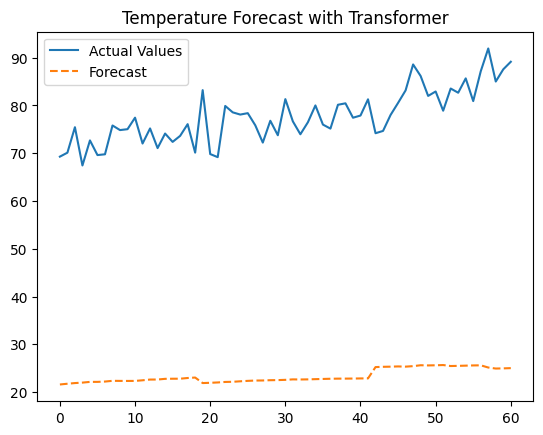

In [ ]:
# Forecasting and evaluation
preds = model.predict(X_test) * y_std + y_mean # Denormalize the forecasts
y_test = y_test * y_std + y_mean # Denormalize the actual values

plt.plot(y_test, label='Actual Values')
plt.plot(preds, label='Forecast', linestyle='dashed')
plt.legend()
plt.title("Temperature Forecast with Transformer")
plt.show()

### Analysis of Results

#### 1. **Loss and Val Loss**
   - **Loss:** Measures the average error on the **training** data.
   - **Val Loss:** Measures the average error on the **validation** data, indicating the model's ability to generalize.

#### 2. **Training Evolution**
   - **Loss consistently decreases**, showing that the model is learning.
   - **Val Loss follows a similar trend** but stabilizes or fluctuates at some point.

#### 3. **Overfitting or Underfitting?**
   - **Overfitting:** If **val_loss > loss** and starts increasing, the model is memorizing training data instead of generalizing.
   - **Underfitting:** If both **loss and val_loss remain high**, the model is not learning enough.

#### 4. **Current Interpretation**
   - The **initial epochs show a strong decrease in loss and val_loss**, indicating proper learning.
   - **After epoch 100, val_loss stabilizes around 7.3**, suggesting a decent generalization.

#### 5. **Possible Improvements**
   - **Regularization:** Dropout and L2 regularization already help prevent overfitting.
   - **Learning Rate Reduction:** Could improve stability in later epochs.
   - **More Data?** If data is limited, generalization might suffer.

### **Conclusion**
- **Good performance** with an **acceptable val_loss** for time series forecasting.
- **Optimization is possible**, but without overfitting.
- **Fine-tuning the learning rate** in later epochs could enhance stability.


## **Early Stopping: Why It's Not a Problem!**

### **Why Is It Not a Problem?**
1. **Prevents Overfitting**  
   - If `val_loss` **stops improving or starts increasing**, the model is learning **noise** instead of generalizing.  
   - Early stopping **prevents memorizing unnecessary details** from the training data.

2. **Saves Time and Resources**  
   - If improvement stops after **30-40 epochs**, running **100 epochs** is **wasteful**.  
   - **Early Stopping** finds the optimal number of epochs **without manual tuning**.

3. **Restores the Best Weights**  
   - With `restore_best_weights=True`, the model **does not use the last epoch’s weights** but the ones from **the best val_loss**.  
   - If it stops at **epoch 40**, it might actually use **epoch 32’s weights**.

---

### **What Happens If Training Stops Early?**
- **Stops at Epoch 30 (out of 100):**  
  The model **stopped improving** after 30 epochs, so the extra 70 epochs were **unnecessary**.

- **Stops at Epoch 70 (out of 100):**  
  The model **kept improving** until epoch 70.

---

### **How to Check If Early Stopping Was Effective?**
After training, check how many epochs were actually used:

```python
print(f"Training stopped at epoch {len(history.history['loss'])}")
